## Data collection

*Document your data collection process and the properties of the data here. Implement, using Python code, to load and preprocess your selected dataset.*

To acquire a large number of Stack Overflow questions regarding C# you can query the official Stack Overflow database with SQL queries at https://data.stackexchange.com/stackoverflow/queries. These queries can only return 50 000 results at a time so multiple queries have to be made to get all the questions from within a specific period of time. The time frame chosen in this report was 2019-09-22 to 2020-11-08. This period of time was chosen since this is the period of time that C# 8 was the current release of C# and the assumption here was that the documentation regarding new features could be the most lacking.

The query used is as follows: <br>
```
SELECT * FROM posts WHERE Tags LIKE '%c#%' AND posts.CreationDate < 'Insert start data here' AND posts.CreationDate > 'Insert end date here'
ORDER BY posts.CreationDate desc
```

Since this operation has to be done in multiple queries the date input will vary but in the end, you will end up with a number of .CSV files containing the data. In our case, we ended up with three files containing 117 527 questions. These files were then combined into one which is the Data.csv file that you can see in the following steps.

### Read the data from the file and output some values to make sure the data read is correct. 

In [24]:
# Importing the necessary libraries
import pandas as pd
from collections import Counter
import operator
import os
import nltk
import matplotlib
import gensim
from sklearn.feature_extraction.text import CountVectorizer
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import re
import numpy as np
from pprint import pprint
# Ignore warnings for a specific error that we can ignore in this application
pd.options.mode.chained_assignment = None  # default='warn'

In [25]:
# Read our data from the data.csv file
stackOverflowData = pd.read_csv(
    './Data.csv',
    encoding='utf-8'
)

In [26]:
# Print the size of the dataset read
print('Number of Rows and Columns:')
print(stackOverflowData.shape)

Number of Rows and Columns:
(117527, 23)


In [27]:
# Print the dates from wich this data is produced
minValue = stackOverflowData['CreationDate'].min()
maxValue = stackOverflowData['CreationDate'].max()
print('Dates from wich the data is produced: ' +
      minValue + ' to ' + maxValue)

Dates from wich the data is produced: 2019-09-22 00:02:14 to 2020-11-08 04:47:27


In [28]:
# This code removes all the questions that are closed or has a negative score since this is an indication
# of a bad question.
stackOverflowData = stackOverflowData[stackOverflowData['ClosedDate'].isnull()]
stackOverflowData = stackOverflowData[stackOverflowData['Score']>=0]
stackOverflowData.shape

(98705, 23)

### The next step is to read the data into a Data Frame and prepare the data for the analysis phase

In [29]:
# Creating a Data Frame with only the necessary columns
df = stackOverflowData[['AcceptedAnswerId', 'Title',
                    'CreationDate', 'Body']]

In [30]:
# Setting the neccessary data to lowercase since this will make sure that uppercase and lowercase words from the 
# data will be treated as equal in the comming algorithms.
df['Title'] = df['Title'].str.lower()

In [31]:
#smaller scaled df
#df = df.head(100)
text = df['Title']
text.shape

(98705,)

In [32]:
# tokenize


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(text))

In [33]:
#create bigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
print(bigram_mod[data_words[0]])

['cannot', 'return', 'value', 'from', 'class', 'that', 'inherits']


In [34]:
#make bigrams, Lemmatize
stop_words = ['the', 'on', 'are', 'is', 'but' 'and', 'in', 'to', 'how', 'for', 'and', 'with', 'can']

In [35]:
# Form Bigrams
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_stopwords = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_stopwords)

print(data_words_bigrams[:1])

[['cannot', 'return', 'value', 'from', 'class', 'that', 'inherits']]


In [36]:
#creat dict
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('cannot', 1),
  ('class', 1),
  ('from', 1),
  ('inherits', 1),
  ('return', 1),
  ('that', 1),
  ('value', 1)]]

In [37]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

KeyboardInterrupt: 

In [17]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.042*"using" + 0.028*"application" + 0.028*"key" + 0.028*"first" + '
  '0.015*"winform" + 0.015*"error" + 0.015*"connection" + 0.015*"nginx" + '
  '0.015*"code" + 0.015*"ef"'),
 (1,
  '0.019*"generated" + 0.019*"two" + 0.019*"randomly" + 0.019*"letters" + '
  '0.019*"inputfield" + 0.019*"text" + 0.019*"check" + 0.019*"do" + '
  '0.019*"whether" + 0.019*"contains"'),
 (2,
  '0.023*"cs" + 0.023*"before" + 0.023*"onpost" + 0.023*"execute" + '
  '0.023*"executed" + 0.023*"method" + 0.023*"set" + 0.023*"cshtml" + '
  '0.023*"block" + 0.023*"it"'),
 (3,
  '0.027*"object" + 0.027*"root" + 0.027*"an" + 0.027*"not" + 0.027*"when" + '
  '0.014*"by" + 0.014*"made" + 0.014*"set" + 0.014*"class" + '
  '0.014*"reference"'),
 (4,
  '0.028*"process" + 0.028*"using" + 0.014*"variables" + 0.014*"read" + '
  '0.014*"microsoft" + 0.014*"center" + 0.014*"app" + 0.014*"environment" + '
  '0.014*"forms" + 0.014*"practice"'),
 (5,
  '0.023*"working" + 0.023*"after" + 0.023*"console" + 0.023*"dot" + '

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.204822 -0.061148       1        1  11.966661
16    -0.149107 -0.021667       2        1   7.961425
17     0.051158  0.137323       3        1   7.580792
12     0.003893 -0.059416       4        1   6.713222
19     0.001015 -0.115524       5        1   6.459371
3     -0.105457 -0.002154       6        1   6.388354
4      0.090264  0.007574       7        1   6.018525
0     -0.007218  0.177649       8        1   5.829327
10     0.001469  0.019626       9        1   5.404423
15    -0.057259 -0.037880      10        1   5.140211
18     0.013986 -0.064715      11        1   4.825046
9      0.001689 -0.049272      12        1   4.644082
6      0.057083  0.038128      13        1   4.075293
1     -0.031192 -0.022945      14        1   3.771084
8     -0.034062  0.021520      15        1   3.637554
2     -0.009495  0.016780      16        1   2.702578
5     -0.007897  0.042469      17        1   2.640943
11    -0.019303 -0.003283      18        1   1.700550
14    -0.002033 -0.009333      19        1   1.576216
7     -0.002356 -0.013731      20        1   0.964343, topic_info=        Term      Freq     Total Category  logprob  loglift
136      net  7.000000  7.000000  Default  30.0000  30.0000
120    using  8.000000  8.000000  Default  29.0000  29.0000
1      class  4.000000  4.000000  Default  28.0000  28.0000
13       not  6.000000  6.000000  Default  27.0000  27.0000
134     core  6.000000  6.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
177   before  0.012297  1.049198  Topic20  -6.4378   0.1951
178    block  0.012297  1.752268  Topic20  -6.4378  -0.3178
179       cs  0.012297  1.049198  Topic20  -6.4378   0.1951
180   cshtml  0.012297  1.671191  Topic20  -6.4378  -0.2704
181  execute  0.012297  1.049198  Topic20  -6.4378   0.1951

[832 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
383       2  0.783540     absent
367       4  0.538704     access
367      11  0.538704     access
495       9  0.836694  accessing
25        2  0.507003        add
...     ...       ...        ...
471      15  0.895173      write
113       1  0.501594    xamarin
113       7  0.501594    xamarin
329       2  0.783540  xdocument
317      14  0.895113      yield

[646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 17, 18, 13, 20, 4, 5, 1, 11, 16, 19, 10, 7, 2, 9, 3, 6, 12, 15, 8])

In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

SyntaxError: non-default argument follows default argument (<ipython-input-22-d09f2486f2aa>, line 1)

In [261]:
# List of words that we want to remove from the dataset 
# We need a method to remove html tags like <p> that are right next to words without a space in between
stopWords = ['code', 'gt', 'i', '<p>i', 'in', 'on', 'is', '<code>', 'gt', 'lt', 'pre', 'quot', 'nofollow', 'li', 'div']

# Remove all the stopwords from the data
df['Title'] = df['Title'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stopWords)]))

# Print to test the remove stopwords function
print('Testa StopWords funktionen: \n')
print(df['Title'].head(4) + '\n')
df['Title'].shape

Testa StopWords funktionen: 

0    cannot return value from class that inherits m...
1    "nullreferenceexception: object reference not ...
2    get parentnode and childnodes from xml with li...
3    how can add a menuitem option context menu edi...
Name: Title, dtype: object


(98705,)

In [23]:
import re
from wordcloud import WordCloud
df['Body'] = df['Body'].map(lambda x: re.sub('[,\.!?]', '', x))
clean = re.compile('[<.*\?>,\.!?]')
df['Body'] = df['Body'].map(lambda x: re.sub(clean, '', x))
df['Body'] = df['Body'].str.replace(r'http\S+', '')
#sumstring = ','.join(list(df['Body'].values))
#wordcloud = WordCloud()
#wordcloud.generate(sumstring)
#wordcloud.to_image()
print(df['Body'].head(1))

<>:3: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \?
<>:3: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \?
<ipython-input-23-9f34eceb0d69>:3: DeprecationWarning: invalid escape sequence \.
  df['Body'] = df['Body'].map(lambda x: re.sub('[,\.!?]', '', x))
<ipython-input-23-9f34eceb0d69>:4: DeprecationWarning: invalid escape sequence \?
  clean = re.compile('[<.*\?>,\.!?]')


ModuleNotFoundError: No module named 'wordcloud'

C:\Users\AxelS\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


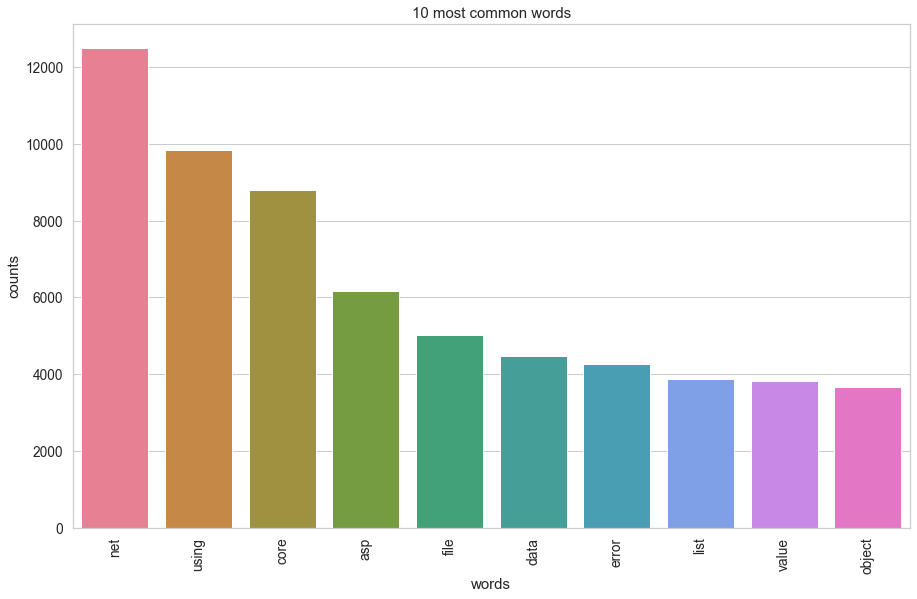

In [262]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['Title'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [263]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 20
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
way need mongodb using best correct action instance information url

Topic #1:
net core asp mvc api web async authentication identity using

Topic #2:
set xml blazor element process using child memory parent component

Topic #3:
file load excel wpf using open assembly path save window

Topic #4:
task using control form text user pdf size graph microsoft

Topic #5:
error exception test google api type unit microsoft getting using

Topic #6:
xamarin forms image event android command uwp script button line

Topic #7:
unity app windows time service connection thread running console start

Topic #8:
linq visual studio query expression does 2019 select lambda using

Topic #9:
azure server file files using function read local data directory

Topic #10:
string convert datetime format search value character using key characters

Topic #11:
data view wpf item loop binding razor items display listview

Topic #12:
list object json array objects parameter values usi

In [264]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

topicdf = display_topics(lda, count_vectorizer.get_feature_names(), 10)
topicdf

,Topic 0 words,Topic 1 words,Topic 2 words,Topic 3 words,Topic 4 words,Topic 5 words,Topic 6 words,Topic 7 words,Topic 8 words,Topic 9 words,Topic 10 words,Topic 11 words,Topic 12 words,Topic 13 words,Topic 14 words,Topic 15 words,Topic 16 words,Topic 17 words,Topic 18 words,Topic 19 words
0,way,net,set,file,task,error,xamarin,unity,linq,azure,string,data,list,project,application,column,null,request,entity,class
1,need,core,xml,load,using,exception,forms,app,visual,server,convert,view,object,page,web,button,value,api,framework,type
2,mongodb,asp,blazor,excel,control,test,image,windows,studio,file,datetime,wpf,json,build,net,row,doesn,send,core,method
3,using,mvc,element,wpf,form,google,event,time,query,files,format,item,array,dll,api,input,model,using,database,generic
4,best,api,process,using,text,api,android,service,expression,using,search,loop,objects,nuget,service,datagridview,work,response,ef,property
5,correct,web,using,open,user,type,command,connection,does,function,value,binding,parameter,package,console,value,returns,post,table,properties
6,action,async,child,assembly,pdf,unit,uwp,thread,2019,read,character,razor,values,vs,core,textbox,validation,data,data,object
7,instance,authentication,memory,path,size,microsoft,script,running,select,local,using,items,using,solution,dependency,number,controller,http,sql,variable
8,information,identity,parent,save,graph,getting,button,console,lambda,data,key,display,pass,errors,injection,datagrid,ajax,httpclient,using,use
9,url,using,component,window,microsoft,using,line,start,using,directory,characters,listview,deserialize,using,library,dynamically,mvc,email,key,interface


In [268]:
def format_topics_sentences (ldamodel=lda, corpus=df, texts=df['Title']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

NameError: name 'optimal_model' is not defined

In [ ]:
df['Topic'].head(100)

In [ ]:
df

In [14]:
whiteList = pd.read_csv(
    './customTopics.csv',
    encoding='utf-8')
mydic = {}
whiteList['C# documentation'] = whiteList['C# documentation'].str.lower()
for topic in whiteList['C# documentation']:
    mydic[topic] = df['Title'].str.contains(topic, regex=False).sum()

In [15]:
mydic

{'readonly member': 4,
 'default interface method': 5,
 'pattern matching enhancement': 1,
 'switch expression': 35,
 'tuple pattern': 0,
 'property pattern': 0,
 'positional pattern': 1,
 'using declaration': 1,
 'disposable ref struct': 0,
 'static local function': 2,
 'nullable reference type': 46,
 'asynchronous stream': 1,
 'asynchronous disposable': 0,
 'indice and range': 0,
 'null-coalescing assignment': 2,
 'unmanaged constructed': 0,
 'interpolated verbatim string': 1,
 'stackalloc nested expression': 0}

<AxesSubplot:>

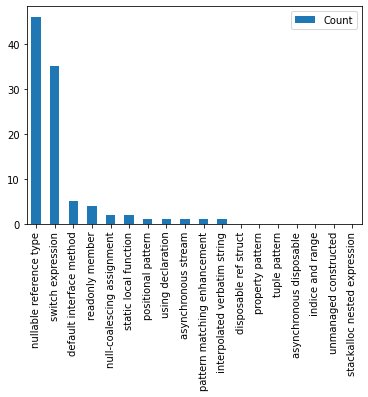

In [16]:
dataframe = pd.DataFrame.from_dict(mydic, orient = 'index', columns=['Count'])
dataframe = dataframe.sort_values(by=['Count'], ascending = False)
dataframe.head(30).plot.bar()

## Data analysis

*Document you choice and motivation for selected data mining method(s) here. Choose a data mining method(s) to use in Python code to perform an analysis of your chosen dataset. Describe why you chose the method(s) and what interesting things you have found from the analysis.*

*Replace the contents of this cell with your own text.*

In [ ]:
# Create a list of the top appearing words. The nrOfWords variable defines how many words the list should contain.
nrOfWords = 10
rslt = Counter(' '.join(df['Body']).split()).most_common(nrOfWords)

# Print out the list created above.
print('\n')
for word in rslt:
    print('{} = {}'.format(word[1], word[0]))

## Evaluation of results

*Document an evaluation your analysis results and describe how potentially actionable they are.*

*Replace the contents of this cell with your own text.*

In [ ]:
# Add your own code

## Schedule and description of project plan

*Rough schedule for the project beyond the pilot study presented in 3-5. This does not have to be advanced, you can simply provide an estimate based upon reported schedules for similar projects in the literature.*

*Replace the contents of this cell with your own text.*

## Ethical aspects that need to be considered

*Are there ethical aspects that need to be considered? Are there legal implications (e.g., personal data / GDPR)? Are there implications if the case organization is a business, public authority, or nonprofit entity?*

*Replace the contents of this cell with your own text.*